## Initialize notebook

In [1]:
import numpy as np
import pandas as pd
import datetime
from ensemble import EnsembleClassifier

from time import time
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

from xgboost.sklearn import XGBClassifier
from scipy.sparse import coo_matrix, hstack, csr_matrix, csc_matrix
from scipy.stats import randint, truncnorm, uniform
from scipy.stats.mstats import gmean
from operator import itemgetter
import random

from sklearn import cluster, mixture, metrics, cross_validation
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors.kde import KernelDensity

## Define custom code

In [2]:
# Utility function to report best scores
def grid_search_report(grid_scores, n_top=3):
  top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
  for i, score in enumerate(top_scores):
    print('Model with rank: {0}'.format(i + 1))
    print('Mean validation score: {0:.3f} (std: {1:.3f})'.format(
          score.mean_validation_score,
          np.std(score.cv_validation_scores)))
    print('Parameters: {0}'.format(score.parameters))
    print('')
    
def compute_error(clf, X, y, n_iter=20):
#   cv = cross_validation.ShuffleSplit(len(y), n_iter=n_iter, train_size=0.5,
#                                      test_size=0.5, random_state=42)
  cv = cross_validation.StratifiedShuffleSplit(y, n_iter=n_iter, train_size=0.8,
                                               test_size=0.2, random_state=42)
  return -cross_validation.cross_val_score(clf, X, y, cv=cv, scoring='log_loss').mean()

## Load data

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample_sub = pd.read_csv('sample_submission.csv')
df_event = pd.read_csv('event_type.csv')
df_log = pd.read_csv('log_feature.csv')
df_resource = pd.read_csv('resource_type.csv')
df_severity = pd.read_csv('severity_type.csv')

## Combine data and visualize 

In [4]:
df_comb = df_train
df_comb['train_test'] = 0
df_test['train_test'] = 1

df_comb = df_comb.drop('fault_severity', axis=1)
df_comb = pd.concat([df_comb, df_test], ignore_index=True)
df_comb = df_comb.set_index('id')
df_comb['location'] = [int(a.replace('location ', '')) for a in df_comb['location']]

tmp = df_event
tmp = tmp.set_index('id')
tmp['event_type'] = [int(a.replace('event_type ', '')) for a in tmp['event_type']]
df_comb = pd.merge(df_comb, tmp, how='left', left_index=True, right_index=True)

tmp = df_log
tmp = tmp.set_index('id')
tmp['log_feature'] = [int(a.replace('feature ', '')) for a in tmp['log_feature']]
df_comb = pd.merge(df_comb, tmp, how='left', left_index=True, right_index=True)

tmp = df_resource
tmp = tmp.set_index('id')
tmp['resource_type'] = [int(a.replace('resource_type ', '')) for a in tmp['resource_type']]
df_comb = pd.merge(df_comb, tmp, how='left', left_index=True, right_index=True)

tmp = df_severity
tmp = tmp.set_index('id')
tmp['severity_type'] = [int(a.replace('severity_type ', '')) for a in tmp['severity_type']]
df_comb = pd.merge(df_comb, tmp, how='left', left_index=True, right_index=True)

df_comb.head()

,location,train_test,event_type,log_feature,volume,resource_type,severity_type
id,,,,,,,
1,601,0,11,68,2,8,1
1,601,0,11,68,2,6,1
1,601,0,11,345,2,8,1
1,601,0,11,345,2,6,1
1,601,0,11,179,1,8,1


In [55]:
sum_feats = 0
for c in df_comb.columns:
  print '%s: %i' % (c, len(np.unique(df_comb[c])))
  sum_feats += len(np.unique(df_comb[c]))
  
print ''
print 'sum total: %i' % sum_feats

location: 1126
train_test: 2
event_type: 53
log_feature: 386
volume: 341
resource_type: 10
severity_type: 5

sum total: 1923


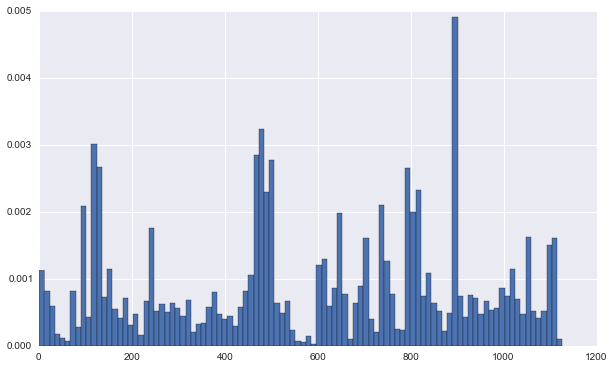

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(np.array(df_comb['location']), 100, normed=True)
plt.show()

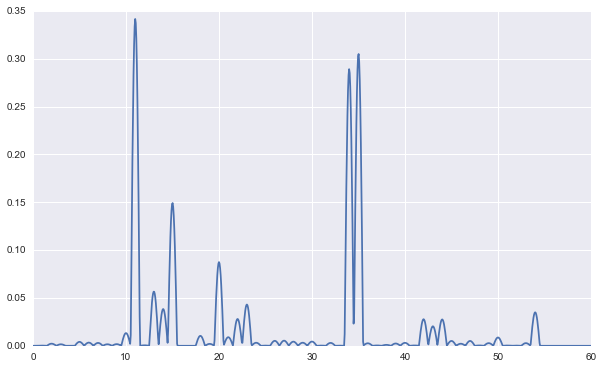

In [6]:
X = np.array(df_comb['event_type'])
X = X.reshape(-1, 1)
X_plot = np.linspace(0, 60, 1000)[:, np.newaxis]

kde = KernelDensity(kernel='cosine', bandwidth=0.5).fit(X)
log_dens = kde.score_samples(X_plot)

plt.figure(figsize=(10, 6))
plt.plot(X_plot[:, 0], np.exp(log_dens))
plt.show()

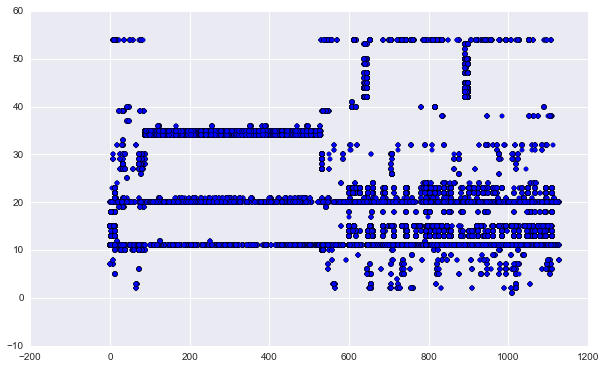

In [61]:
plt.figure(figsize=(10, 6))
plt.scatter(np.array(df_comb['location']), np.array(df_comb['event_type']))
plt.show()

In [34]:
a = df_comb[['resource_type', 'severity_type']]
a = a.drop_duplicates()
a = a.reset_index(drop=True)
a['map'] = a.index
len(a)

29

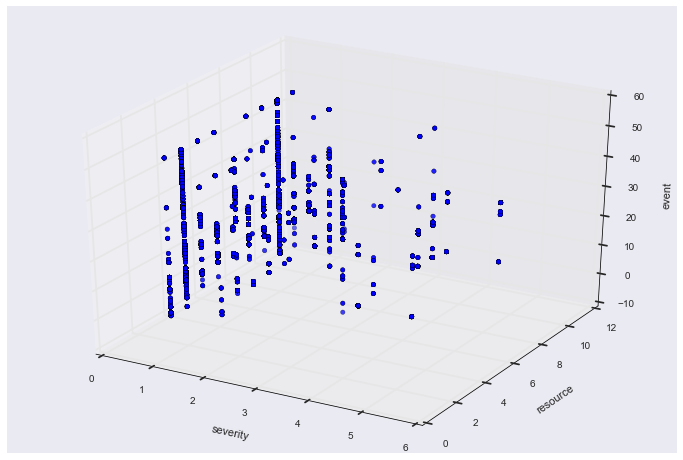

In [11]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(df_comb['severity_type']), 
           np.array(df_comb['resource_type']),
           np.array(df_comb['event_type']))
ax.set_xlabel('severity')
ax.set_ylabel('resource')
ax.set_zlabel('event')
plt.show()

## Create feature and label matrices (approach #1)

In [41]:
idx_train = len(df_train)
df_all = df_comb

y_train = df_train['fault_severity']

# hist, edges = np.histogram(np.array(df_all['location']), 100)
# df_all['location'] = np.digitize(np.array(df_all['location']), edges)

# hist, edges = np.histogram(np.array(df_all['log_feature']), 40)
# df_all['log_feature'] = np.digitize(np.array(df_all['log_feature']), edges)

df_all = df_all.drop(['volume'], axis=1)

df_all.head()

,location,train_test,event_type,log_feature,resource_type,severity_type,id
id,,,,,,,
1,601,0,11,68,8,1,1
1,601,0,11,68,6,1,1
1,601,0,11,345,8,1,1
1,601,0,11,345,6,1,1
1,601,0,11,179,8,1,1


In [42]:
tmp = df_comb
tmp['id'] = tmp.index
tmp = tmp.reset_index(drop=True)
df_vol = tmp[['id', 'volume']]

vol_mean = df_vol.groupby('id', sort=False).mean()
df_vol = df_vol.groupby('id', sort=False).sum()
df_vol['vol_mean'] = vol_mean

In [43]:
ohe_feats = ['location', 'event_type', 'log_feature', 'resource_type', 'severity_type']
for f in ohe_feats:
  tmp = pd.get_dummies(df_all[f], prefix=f)
  df_all = df_all.drop([f], axis=1)
  df_all = pd.concat((df_all, tmp), axis=1)

df_all['id'] = df_all.index
df_all = df_all.reset_index(drop=True)
df_all = df_all.groupby('id', sort=False).sum()

df_all = pd.merge(df_all, df_vol, how='left', left_index=True, right_index=True)
df_all.head()

,train_test,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,...,resource_type_8,resource_type_9,resource_type_10,severity_type_1,severity_type_2,severity_type_3,severity_type_4,severity_type_5,volume,vol_mean
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,6,0,0,12,0,0,0,0,20,1.666667
2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,10,0,0,0,10,1.000000
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,2,2.000000
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,3,3.000000
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,0,34,8.500000


In [44]:
df_X_train = df_all[df_all['train_test'] == 0]
df_X_test = df_all[df_all['train_test'] > 0]

X_train = np.array(df_X_train)
X_train = coo_matrix(X_train)
X_train = X_train.tocsr()

X_test = np.array(df_X_test)
X_test = coo_matrix(X_test)
X_test = X_test.tocsr()

print 'X_train shape: (%i, %i)' % (np.shape(X_train)[0], np.shape(X_train)[1])
print 'X_test shape: (%i, %i)' % (np.shape(X_test)[0], np.shape(X_test)[1])

X_train shape: (7381, 1583)
X_test shape: (11171, 1583)


## Create feature and label matrices (approach #2)

In [7]:
df_all = df_train
df_all = df_all.drop('fault_severity', axis=1)
idx_train = len(df_train)

df_all = pd.concat([df_all, df_test], ignore_index=True)
df_all = df_all.set_index('id')

y_train = df_train['fault_severity']

# merge with event type
tmp = pd.get_dummies(df_event['event_type'])
tmp.insert(0, 'id', df_event['id'])
tmp = tmp.groupby('id', sort=False).sum()

df_all = pd.merge(df_all, tmp, how='left', left_index=True, right_index=True)
# df_all['location'] = [int(a.replace('location ', '')) for a in df_all['location']]
# hist, edges = np.histogram(np.array(df_all['location']), 200)
# df_all['location'] = np.digitize(np.array(df_all['location']), edges)

tmp = pd.get_dummies(df_all['location'], prefix='location')
df_all = df_all.drop('location', axis=1)
df_all = pd.concat((df_all, tmp), axis=1)

# merge with log feature and volume
tmp = df_log[['id', 'log_feature']]
# tmp['log_feature'] = [int(a.replace('feature ', '')) for a in tmp['log_feature']]
# hist, edges = np.histogram(np.array(tmp['log_feature']), 40)
# tmp['log_feature'] = np.digitize(np.array(tmp['log_feature']), edges)

tmp = pd.get_dummies(tmp['log_feature'], prefix='log_feature')
# tmp = tmp.set_index('id')
# tmp = pd.get_dummies(df_all['log_feature'])
tmp.insert(0, 'id', df_log['id'])
tmp = tmp.groupby('id', sort=False).sum()
df_all = pd.merge(df_all, tmp, how='left', left_index=True, right_index=True)

# tmp = pd.get_dummies(df_log['volume'])
# tmp.insert(0, 'id', df_log['id'])
# tmp = tmp.groupby('id', sort=False).sum()
# df_all = pd.merge(df_all, tmp, how='left', left_index=True, right_index=True)

tmp = df_log
tmp = tmp.drop('log_feature', axis=1)
log_mean = tmp.groupby('id', sort=False).mean()
# log_std = tmp.groupby('id', sort=False).std()
df_all.insert(0, 'log_mean', log_mean['volume'])
# df_all.insert(0, 'log_std', log_std['volume'])

# merge with resource type
tmp = pd.get_dummies(df_resource['resource_type'])
tmp.insert(0, 'id', df_resource['id'])
tmp = tmp.groupby('id', sort=False).sum()
df_all = pd.merge(df_all, tmp, how='left', left_index=True, right_index=True)

# merge with severity type
tmp = pd.get_dummies(df_severity['severity_type'])
tmp.insert(0, 'id', df_severity['id'])
tmp = tmp.groupby('id', sort=False).sum()
df_all = pd.merge(df_all, tmp, how='left', left_index=True, right_index=True)

# resource, severity combo
tmp1 = df_resource
tmp1 = tmp1.set_index('id')
tmp2 = df_severity
tmp2 = tmp2.set_index('id')

df_rs = pd.merge(tmp1, tmp2, how='left', left_index=True, right_index=True)
df_map = df_rs.drop_duplicates()
df_rs['id'] = df_rs.index
df_rs = df_rs.reset_index(drop=True)

df_map = df_map.reset_index(drop=True)
df_map['map'] = df_map.index
rs_map = {df_map['resource_type'][ii] + ' ' + df_map['severity_type'][ii]: df_map['map'][ii] for ii in range(len(df_map))}
df_rs['rs'] = [rs_map[df_rs['resource_type'][ii] + ' ' + df_rs['severity_type'][ii]] for ii in range(len(df_rs))]
df_rs = df_rs.drop(['resource_type', 'severity_type'], axis=1)
# df_rs = df_rs.set_index('id')

tmp = pd.get_dummies(df_rs['rs'], prefix='rs')
tmp.insert(0, 'id', df_rs['id'])
tmp = tmp.groupby('id', sort=False).sum()
df_all = pd.merge(df_all, tmp, how='left', left_index=True, right_index=True)

# df_all = df_all.fillna(value=-1)
np.shape(df_all)

(18552, 1611)

In [8]:
X_all = np.array(df_all)
X_all = coo_matrix(X_all) 

X_train = X_all.tocsr()[:idx_train, :]
X_test = X_all.tocsr()[idx_train:np.shape(X_all)[0], :]

print 'X_train shape: (%i, %i)' % (np.shape(X_train)[0], np.shape(X_train)[1])
print 'X_test shape: (%i, %i)' % (np.shape(X_test)[0], np.shape(X_test)[1])

X_train shape: (7381, 1611)
X_test shape: (11171, 1611)


## Grid search

In [115]:
n_iter_search = 20

print 'XGBClassifier'
cv = cross_validation.StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=42)
clf = XGBClassifier(nthread=4, objective='multi:softprob', )
# specify parameters and distributions to sample from
param_dist = {'n_estimators': randint(25, 1000),
              'max_depth': randint(3, 11),
              'learning_rate': uniform(0.001, 0.3),
              'subsample': uniform(0.01, 1.0),
              'colsample_bytree': truncnorm(0.01, 1.0),
              'min_child_weight': randint(1, 5)}

# run randomized search
random_search_xgb = RandomizedSearchCV(clf, param_distributions=param_dist,
                                       n_iter=n_iter_search, scoring='log_loss',
                                       n_jobs=4, cv=cv)

start = time()
random_search_xgb.fit(X_train, y_train)
print('RandomizedSearchCV took %.2f seconds for %d candidates'
      ' parameter settings.' % ((time() - start), n_iter_search))
grid_search_report(random_search_xgb.grid_scores_)

# print ''
# print 'ExtraTreesClassifier'
# cv = cross_validation.StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=42)
# clf = ExtraTreesClassifier(n_jobs=4, random_state=42, )
# # specify parameters and distributions to sample from
# param_dist = {'n_estimators': randint(25, 1000),
#               'min_samples_split': randint(2, 10),
#               'min_samples_leaf': randint(1, 10),
#               'criterion': ['entropy', 'gini']}

# # run randomized search
# random_search_xt = RandomizedSearchCV(clf, param_distributions=param_dist,
#                                       n_iter=n_iter_search, scoring='log_loss',
#                                       n_jobs=4, cv=cv)

# start = time()
# random_search_xt.fit(X_train, y_train)
# print('RandomizedSearchCV took %.2f seconds for %d candidates'
#       ' parameter settings.' % ((time() - start), n_iter_search))
# grid_search_report(random_search_xt.grid_scores_)

XGBClassifier
RandomizedSearchCV took 146.55 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.556 (std: 0.011)
Parameters: {'colsample_bytree': 0.39786199406487127, 'learning_rate': 0.035517148843314916, 'min_child_weight': 1, 'n_estimators': 783, 'subsample': 0.6044322124715861, 'max_depth': 8}

Model with rank: 2
Mean validation score: -0.564 (std: 0.011)
Parameters: {'colsample_bytree': 0.33188978466746738, 'learning_rate': 0.1337876243103542, 'min_child_weight': 3, 'n_estimators': 711, 'subsample': 0.9133110425060593, 'max_depth': 3}

Model with rank: 3
Mean validation score: -0.573 (std: 0.011)
Parameters: {'colsample_bytree': 0.23918050472309432, 'learning_rate': 0.22591358581058477, 'min_child_weight': 3, 'n_estimators': 442, 'subsample': 0.8027624678512595, 'max_depth': 6}



## Single model

In [64]:
params = {'min_samples_split': 6, 'n_estimators': 826, 'criterion': 'gini', 'min_samples_leaf': 1}
clf = ExtraTreesClassifier(n_jobs=4, random_state=42, class_weight='auto', **params)

compute_error(clf, X_train, y_train, n_iter=5)

0.62383376251504374

In [139]:
params = {'colsample_bytree': 0.58097287794373464, 'scale_pos_weight': 0.44124210321506946,
          'learning_rate': 0.11250975103096984, 'n_estimators': 519, 'subsample': 0.9986943311413887,
          'max_depth': 7}
clf = XGBClassifier(nthread=4, objective='multi:softprob', **params)

compute_error(clf, X_train, y_train, n_iter=5)

0.95875127236514202

In [69]:
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)

## Create ensemble (i.e., stacked) classifier CV, and predict

In [19]:
top_scores = sorted(random_search_xgb.grid_scores_, key=itemgetter(1), reverse=True)
clfs = [XGBClassifier(nthread=4, objective='multi:softprob', seed=42, **top_scores[ii].parameters) 
        for ii in range(3)]

top_scores = sorted(random_search_xt.grid_scores_, key=itemgetter(1), reverse=True)
clfs2 = [ExtraTreesClassifier(n_jobs=4, random_state=42, **top_scores[ii].parameters) 
         for ii in range(3)]

for ii in range(len(clfs)):
  clfs.append(clfs2[ii])

In [20]:
eclf = EnsembleClassifier(clfs=clfs, voting='soft')
compute_error(eclf, X_train, y_train, n_iter=5)

0.52607605210715636

In [21]:
eclf.fit(X_train, y_train)
y_pred = eclf.predict_proba(X_test)

## Try NN

In [24]:
from sknn.mlp import Classifier, Layer
from sknn.platform import gpu32

In [15]:
start = time()
nn = Classifier(layers=[Layer('Softmax')], learning_rate=0.01, n_iter=3, random_state=42)
nn.fit(X_train, y_train)
print 'time to train: %.2f seconds' % (time() - start)

time to train: 2406 seconds


## Convert to submission

In [70]:
df_pred = pd.DataFrame(y_pred, columns=['predict_0', 'predict_1', 'predict_2'])
df_pred.insert(0, 'id', df_test['id'])
df_pred.head()

,id,predict_0,predict_1,predict_2
0,11066,0.958707,0.040752,0.000541
1,18000,0.260293,0.119018,0.620690
2,16964,0.989899,0.009976,0.000124
3,4795,0.536059,0.457295,0.006646
4,3392,0.369821,0.491362,0.138817


In [71]:
df_pred.to_csv('my_submission.csv', sep=',', index=False)